In [1]:
# !apt update
# !apt install ffmpeg libsm6 libxext6 -y

In [2]:
# !pip install opencv-contrib-python

In [3]:
# !pip install config 

In [4]:
# !pip install gdown

In [5]:
# !pip install imblearn

In [6]:
# !pip install tensorflow

In [7]:
import gdown
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
import tensorflow as tf
import pandas as pd
import seaborn as sns
import math

from PIL import Image
from zipfile import ZipFile 
from keras.applications import resnet
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory as img_data_dir
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *


from sklearn.metrics import f1_score, accuracy_score
from imblearn.metrics import sensitivity_score, specificity_score
from keras.applications.imagenet_utils import decode_predictions

In [8]:
# url =  'https://drive.google.com/uc?id=1jyW1ozIz71LhLGCuh7GYQCP1IcP_IEZy'
# output = 'archive.zip'
# gdown.download(url, output, quiet=False)
# with ZipFile(output, 'r') as zipObj: # Extract all the contents of zip file in current directory 
#   zipObj.extractall() 

In [9]:
# url =  'https://drive.google.com/uc?id=1SJcZEZEvyxcmoaM7nL3Mwnp_jJs-avOe'
# output = 'archive2.zip'
# gdown.download(url, output, quiet=False)
# with ZipFile(output, 'r') as zipObj: # Extract all the contents of zip file in current directory 
#   zipObj.extractall() 

In [10]:
def compare(y1, y2):
  return sum([y1[i]==y2[i] for i in range(len(y1))])

In [11]:
def normalizacion(data):
  min = np.min(data)
  max = np.max(data)
  if max == min:
    return np.ones(data.shape)
  return (data - min) / (max - min)

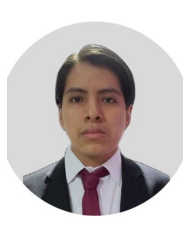

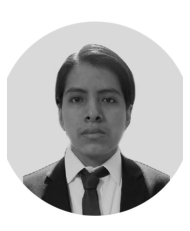

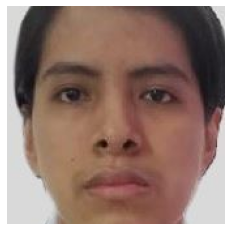

In [12]:
# reading image
original_image = cv2.imread("mes.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.axis("off")
plt.show()

# transform to grayscale
grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
plt.imshow(grayscale_image, cmap="gray")
plt.axis("off")
plt.show()

# cropping image to only face
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
column, row, width, height = face_cascade.detectMultiScale(grayscale_image)[0]
cropped_image = original_image[row:(row+height), column:(column+width)]
plt.imshow(cropped_image, cmap="gray")
plt.axis("off")
plt.show()

In [4]:
# folder = "CK+"
folder = "images/train"
expressions = os.listdir(folder)
sizes = [48, 128, 224]
if 'contempt' in expressions:
    expressions.remove('contempt')
print(expressions)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
class_id = {}
cont = 0
for expression in expressions:
    class_id[expression] = cont
    cont += 1
print(class_id)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [15]:
suma = 0
for expression in expressions:
    path = folder+"/"+expression
    images = os.listdir(path)
    print(expression, len(images))
    suma += len(images)
print("Total: ", suma)

angry 3993
disgust 436
fear 4103
happy 7164
neutral 4982
sad 4938
surprise 3205
Total:  28821


In [8]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

list_img_48 = [[[[]]]]
list_img_128 = [[[[]]]]
list_img_224 = [[[[]]]]
y = []

for expression in expressions:
    path = folder+"/"+expression
    images = os.listdir(path)
    print(expression)
    for i in range(len(images)):
        image = images[i]
        img = cv2.imread(path+"/"+image)

        # COMENTAR ESTE BLOQUE EN CASO DE CORRER EL PRIMER DATASET
        if i == 200:
            break
        cropped_image = img
        # FIN DEL COMENTARIO
        
        # COMENTAR ESTE BLOQUE EN CASO DE CORRER EL SEGUNDO DATASET
        # grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # column, row, width, height = face_cascade.detectMultiScale(grayscale_image)[0]
        # cropped_image = img[row:(row+height), column:(column+width)]
        # FIN DEL COMENTARIO

        resize_img = cv2.resize(cropped_image, (sizes[0], sizes[0]))
        if len(list_img_48[0][0][0]) == 0:
            list_img_48[0] = resize_img
        else:
            list_img_48.append(resize_img)

        resize_img = cv2.resize(cropped_image, (sizes[1], sizes[1]))
        if len(list_img_128[0][0][0]) == 0:
            list_img_128[0] = resize_img
        else:
            list_img_128.append(resize_img)

        resize_img = cv2.resize(cropped_image, (sizes[2], sizes[2]))
        if len(list_img_224[0][0][0]) == 0:
            list_img_224[0] = resize_img
        else:
            list_img_224.append(resize_img)

        y.append(class_id[expression])
    print(len(y), len(list_img_224))

angry
200 200
disgust
400 400
fear
600 600
happy
800 800
neutral
1000 1000
sad
1200 1200
surprise
1400 1400


In [17]:
# for expression in os.listdir("images/train/"):
#     print(expression, len(os.listdir("images/train/"+expression)))

In [18]:
resnet_50 = resnet.ResNet50(include_top = False, 
                                   weights = 'imagenet', 
                                   input_shape = (224, 224, 3),
                                   pooling = 'avg',
                                   classes = len(expressions))
resnet_101 = resnet.ResNet101(include_top = False, 
                                   weights = 'imagenet', 
                                   input_shape = (224, 224, 3),
                                   pooling = 'avg',
                                   classes = len(expressions))

171446536/171446536 [==============================] - 19s 0us/step


In [19]:
# import tensorflow as tf
# print(tf.version.VERSION)
# gpus = tf.config.experimental.list_physical_devices(device_type="CUDA")
# gpus

In [ ]:
list_result_resnet50 = []
list_result_resnet101 = []

for img in list_img_224:
    x = np.expand_dims(img, axis=0)
    list_result_resnet50.append(resnet_50.predict(x))
    list_result_resnet101.append(resnet_101.predict(x))

In [55]:
vgg_19 = VGG19(include_top = False, 
            weights = 'imagenet', 
            input_shape = (48, 48, 3),
            pooling = 'avg',
            classes = len(expressions))

In [ ]:
list_result_vggnet19 = []
for img in list_img_48:
    x = np.expand_dims(img, axis=0)
    list_result_vggnet19.append(vgg_19.predict(x))

In [25]:
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [26]:
# x = list_result_vggnet19
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)

In [27]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

In [28]:
train_gen = datagen.flow_from_directory(
        'CK+',
        target_size = (224, 224),
        batch_size = 64,
        class_mode = 'categorical',
        subset = 'training')

Found 725 images belonging to 7 classes.


In [29]:
test_gen = datagen.flow_from_directory(
        'CK+',
        target_size = (224, 224),
        batch_size = 64,
        class_mode = 'categorical',
        subset = 'validation')

Found 177 images belonging to 7 classes.


In [30]:
opt = Adam(learning_rate=0.001)

In [ ]:
# os.mkdir('img')

In [13]:
def test(x_train, y_train, x_test, y_test, i = -1, model = "", kernel_types = ["linear", "poly"]):
    for kernel_type in kernel_types:
        print(kernel_type)
        classifier = svm.SVC(kernel = kernel_type, degree = 2, gamma = 0.1)
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

        matrix = confusion_matrix(y_test, y_pred)
        df2 = pd.DataFrame(matrix, index=expressions, columns=expressions)
        sns.heatmap(df2, annot=True, cbar=None, cmap="Greens")
        plt.title("Confusion Matrix"), plt.tight_layout()
        plt.xlabel("Predicted")
        plt.ylabel("Real")

        if model != "":
            plt.savefig("img/"+kernel_type+"_"+model+"_"+str(i)+".png")
        plt.show()

        print("Sensitivity")
        print(round(100*sensitivity_score(y_test, y_pred, average = 'macro'), 2))
        print("Specificity")
        print(round(100*specificity_score(y_test, y_pred, average = 'macro'), 2))
        print("F1-score")
        print(round(100*f1_score(y_test, y_pred, average = 'macro'), 2))
        print("Accuracy")
        print(round(100*accuracy_score(y_test, y_pred), 2))

In [34]:
def k_fold(k, X, Y, model = ""):
    random.seed(10)
    aux = list(zip(X, Y))
    np.random.shuffle(aux)
    x, y = zip(*aux)
    x = list(x)
    y = list(y)    

    step = math.floor((1/k)*len(x))
    stop = len(x)

    if len(x)%k != 0:
        stop -= step

    index = [i for i in range(len(x))]
    cont = 1
    for j in range(0, stop, step):
        print(cont)
        x_test, y_test = x[j:(j+step)], y[j:(j+step)]
        x_train, y_train = [], []
        ids = list(set(index).difference(set(index[j:(j+step)])))
        for id_ in ids:
            x_train.append(x[id_])
            y_train.append(y[id_])

        x_test = np.array(x_test)
        y_test = np.array(y_test)
        x_train = np.array(x_train)
        y_train = np.array(y_train)

        if len(x_train.shape) == 3:
            nsamples, nx, ny = x_train.shape
            x_train = x_train.reshape((nsamples,nx*ny))

            nsamples, nx, ny = x_test.shape
            x_test = x_test.reshape((nsamples,nx*ny))

        test(x_train, y_train, x_test, y_test, cont, model)
        cont += 1

In [44]:
kernel_types = ['linear', 'poly', 'rbf']

Random
linear


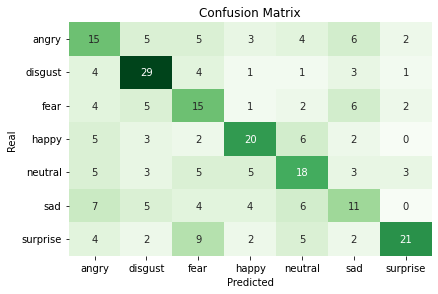

Sensitivity
45.67
Specificity
91.03
F1-score
45.69
Accuracy
46.07
poly


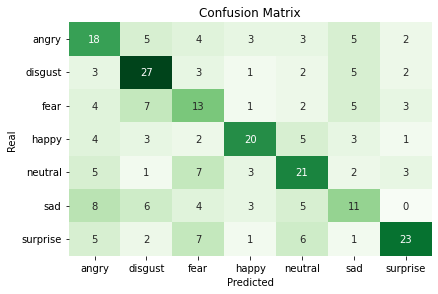

Sensitivity
46.92
Specificity
91.26
F1-score
47.08
Accuracy
47.5


In [48]:
x = list_result_resnet50

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)

x_train = np.array(x_train)
x_test = np.array(x_test)

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny))

print("Random")
test(x_train, y_train, x_test, y_test)
# print("K-fold")
# k_fold(3, x, y, "resnet50")

In [ ]:
x = list_result_resnet101

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)

x_train = np.array(x_train)
x_test = np.array(x_test)

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny))

print("Random")
test(x_train, y_train, x_test, y_test)
# print("K-fold")
# k_fold(3, x, y, "resnet101")

In [9]:
import torch
from alexnet_pytorch import AlexNet
from PIL import Image
from torchvision import transforms

model = AlexNet.from_pretrained("alexnet")
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-4])
#model.eval()

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

list_alexnet = []

for img in list_img_128:
    input_tensor = preprocess(Image.fromarray(img))
    input_batch = input_tensor.unsqueeze(0)
    output = model(input_batch)
    vector = output.detach().numpy()[0]
    list_alexnet.append(vector)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Diego/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loaded pretrained weights for alexnet


Random
linear


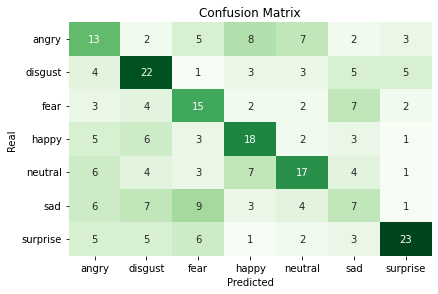

Sensitivity
40.63
Specificity
90.19
F1-score
40.49
Accuracy
41.07
poly


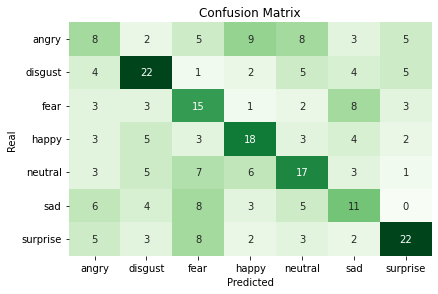

Sensitivity
40.07
Specificity
90.08
F1-score
39.79
Accuracy
40.36


In [19]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from imblearn.metrics import sensitivity_score, specificity_score
x = list_alexnet

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)

x_train = np.array(x_train)
x_test = np.array(x_test)

print("Random")
test(x_train, y_train, x_test, y_test)
# print("K-fold")
# k_fold(3, x, y, "alexnet")

Random
linear


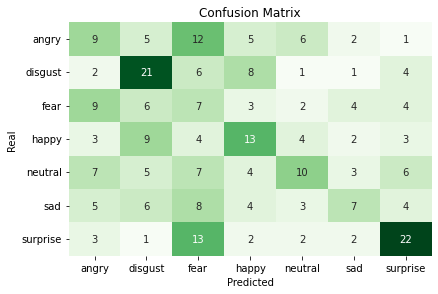

Sensitivity
31.02
Specificity
88.65
F1-score
31.14
Accuracy
31.79
poly


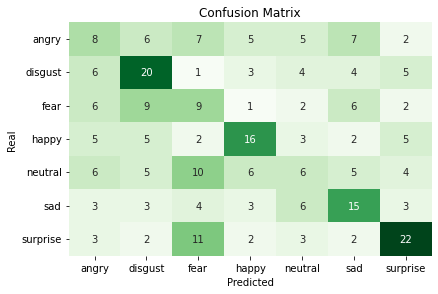

Sensitivity
34.01
Specificity
89.06
F1-score
33.6
Accuracy
34.29


In [58]:
x = list_result_vggnet19

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)

x_train = np.array(x_train)
x_test = np.array(x_test)

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny))

print("Random")
test(x_train, y_train, x_test, y_test)
# print("K-fold")
# k_fold(3, x, y, "vgg19")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4867ecad-186c-4369-a853-1a69f7062200' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>